In [1]:
import numpy as np
from scipy.special import binom
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
class GraphVisualization:
    """
    GraphVisualization(G).visualize()
    """
    
    def __init__(self, g = None):
          
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = [] if g == None else list(g.edges())
          
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
        

# def plot_graph(g):
#     G = GraphVisualization()
#     for edge in g.edges():
#         G.addEdge(edge[0], edge[1])
#     G.visualize()

def plot_edges(edge_list):
    G = GraphVisualization()
    for edge in edge_list:
        G.addEdge(edge[0], edge[1])
    G.visualize()
      

def edge_list(g):
    graph = defaultdict(list)
    for u,v in list(g.edges()):
        graph[u].append(v)
        graph[v].append(u)
    return graph

# This class represents an undirected graph
# using adjacency list representation
class CutGraph:
    def __init__(self, g = None):
        self.V = 0 if (g == None or len(list(g.nodes())) == 0) else max(list(g.nodes()))+1 # No. of vertices
        self.g = g
        self.graph = defaultdict(list) if g == None else edge_list(g) # default dictionary to store graph
        self.Time = 0
  
    # function to add an edge to graph
    def addEdge(self, u, v):
        self.graph[u].append(v)
        self.graph[v].append(u)        
    def APUtil(self, u, visited, ap, parent, low, disc):
 
        # Count of children in current node
        children = 0
 
        # Mark the current node as visited and print it
        visited[u]= True
 
        # Initialize discovery time and low value
        disc[u] = self.Time
        low[u] = self.Time
        self.Time += 1
 
        # Recur for all the vertices adjacent to this vertex
        for v in self.graph[u]:
            # If v is not visited yet, then make it a child of u
            # in DFS tree and recur for it
            if visited[v] == False :
                parent[v] = u
                children += 1
                self.APUtil(v, visited, ap, parent, low, disc)
 
                # Check if the subtree rooted with v has a connection to
                # one of the ancestors of u
                low[u] = min(low[u], low[v])
 
                # u is an articulation point in following cases
                # (1) u is root of DFS tree and has two or more children.
                if parent[u] == -1 and children > 1:
                    ap[u] = True
 
                #(2) If u is not root and low value of one of its child is more
                # than discovery value of u.
                if parent[u] != -1 and low[v] >= disc[u]:
                    ap[u] = True   
                     
                # Update low value of u for parent function calls   
            elif v != parent[u]:
                low[u] = min(low[u], disc[v])
 
 
    # The function to do DFS traversal. It uses recursive APUtil()
    def find_cut(self):
  
        # Mark all the vertices as not visited
        # and Initialize parent and visited,
        # and ap(articulation point) arrays
        visited = defaultdict(lambda: False)
        disc = defaultdict(lambda: float("inf"))
        low = defaultdict(lambda: float("inf"))
        parent = defaultdict(lambda: -1)
        ap = defaultdict(lambda: False) # To store articulation points
 
        # Call the recursive helper function
        # to find articulation points
        # in DFS tree rooted with vertex 'i'
        for i in range(self.V):
            if visited[i] == False:
                self.APUtil(i, visited, ap, parent, low, disc)
        for v, value in ap.items():
            if value == True: 
#                 print (v ,end=" "
                yield v
                
    def cut(self):
        output = self.g.copy()
        cut_vertices = list(self.find_cut())
        output.remove_nodes_from(cut_vertices)
        cc = list(nx.connected_components(output))
        max_vertex = self.V
        for cut in cut_vertices:
            for component in cc:
                for v in component:
                    if cut in self.graph[v]: output.add_edge(max_vertex,v)
                max_vertex += 1
        return output

In [3]:
def find_class(g_data, iso_classes):
    for i, class_data in enumerate(iso_classes):
#         # change here to reproduce the error
#         if nx.is_isomorphic(g_data[0], class_data[0]) and g_data[1] == class_data[1]:
        if nx.is_isomorphic(CutGraph(g_data[0]).cut(), CutGraph(class_data[0]).cut()) and g_data[1] == class_data[1]:
            return i
    return -1


#Prunes all edges not part of any cycle
def pruneEdges(H):
    #print ("Pruning", H.edges())
    m = len(H.edges())


    while True:
        toRemove = []
        for v in H.nodes():
            if H.degree(v) <= 1:
                toRemove += [v]
        if len(toRemove) > 0:
            H.remove_nodes_from(toRemove)
        else:
            #combine all connected components
            comps = (list)(nx.connected_components(H))
            if len(comps) > 1:
                u = min(comps[0])
                for comp in comps[1:]:
                    H = nx.contracted_nodes(H, u, min(comp))
            #print ("Pruned to ", H.edges())
            return (H, m - len(H.edges()))



def pruned_atlas(size):
    atlas = sorted(nx.graph_atlas_g()[1:], key = lambda G: G.number_of_edges())
    iso_classes = []
    unpruned_list = []

    for G in atlas:
        #reduce to "isomorphism class" of matroid
        data = pruneEdges(G.copy())

        #if already in list, continue
        if find_class(data, iso_classes) != -1:
            continue

        #add this to the list of classes found    
        iso_classes += [data]
        unpruned_list += [G]
#         unpruned_list += [(G,data[0],data[1])]

        if len(iso_classes) >= size:
            break
    return unpruned_list

In [4]:
q = 3

#Checks prop 2.5 for graphs on up to 9 vertices.
def check_with_coeffs(coeffs):
    print("number of coefficients", len(coeffs))
    mat = np.load('subg_counts_9.npy')
    print("size of mat", len(mat), len(mat[0]))
    print(mat[:20])
    length = min(len(coeffs), len(mat[0]))
    graphs = nx.read_graph6('graph9.g6') #https://users.cecs.anu.edu.au/~bdm/data/graph9.g6
    denom = int(3 ** 9)
    
    print("Checking ",  len(graphs), " constraints.")
    max_abs = 0
    ma_ind = 0
    for i, G in enumerate(graphs):
        if i == 0:
            continue
        s = abs(sum(mat[i][j] * coeffs[j] for j in range(length)))

        if s > max_abs:
            if s != 1000 * denom:
                max_abs = s
            print("Absolute value of ", s, "/1000*3^9 = ", round(s/(1000*denom),4), " achieved by graph ", graphs[i].edges())

        elif i %10000 == 0:
            print("Checked ", i, "/", len(graphs))
    print ("Complete")

#Computes the maximum appearing in (7) from Proposition 3.5
def count_bounds_with_coeffs(coeffs):
    threecolor_mat = np.load('subg_counts_9.npy') #Pre-generated data

    graphs = nx.read_graph6('graph9.g6') #https://users.cecs.anu.edu.au/~bdm/data/graph9.g6

    max_count = 0
    max_ind = 0
    best_counts = []
    print("Checking ",  len(graphs), " constraints.")
    for i, G in enumerate(graphs):
        
        row = threecolor_mat[i]
        extra_comps = len(list(nx.connected_components(G))) - 1
        #since overall graph is connected, can be only one way out of 3 cyclic shifts to color each comp after the first
        count = sum(abs(row[j] * coeffs[j] * DC(vertices(j))) for j in range(len(coeffs))) / int(3 ** extra_comps)
        if count > max_count:
            max_ind = i
            max_count = count
            best_counts = [row[j] / 3 ** extra_comps for j in range(len(coeffs))]
            print("Value of ", count, "/324000*3^9 = ", round(count/(324000*(3 ** 9)),4), " achieved by graph ", G.edges())
        if i % 10000 == 0:
            print("Checked ", i, "/", len(graphs))
    print ("Complete")
    return max_count

#For integer computation returns 324 * DC_{3,9}(n)
def DC(n):
    dc_vals = [1/3, 10/27, 5/12, 10/21, 5/9, 2/3, 5/6, 10/9, 55/27, 715/81]
    dc_vals_int = [int(324 * x) for x in dc_vals]
    if n < 10:
        return dc_vals_int[n]
    return 10000

#maximum number of vertices among graphs in each equivalence class
def vertices(ind):
    verts = [0, 2, 4, 3, 6, 5, 4, 8, 4, 7, 6, 5, 10, 4, 6, 7, 5, 5, 9, 8, 7, 6, 12, 8, 5, 5, 5, 8, 8, 7, 7, 8, 6, 6, 6]
    if ind < 35:
        return verts[ind]
    return 10

def index_in_atlas(atlas, graph):
    for ind, graph_prime in enumerate(atlas):
        data = pruneEdges(graph)
        data_prime = pruneEdges(graph_prime)
        if nx.is_isomorphic(data[0], data_prime[0]) and data[1] == data_prime[1]:
            return ind

    print("Could not find graph in atlas")
    return len(atlas)

In [5]:
def create_nx_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

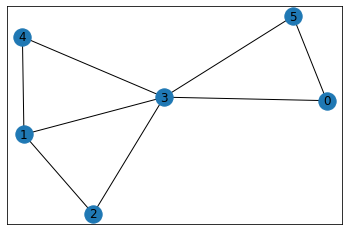

3 

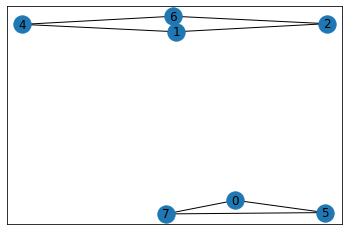

In [88]:
target = create_nx_graph([[1,2],[1,3],[1,4],[2,3],[3,4],[3,5],[3,0],[5,0]])
GraphVisualization(target).visualize()
blocks = CutGraph(target).cut()
GraphVisualization(blocks).visualize()

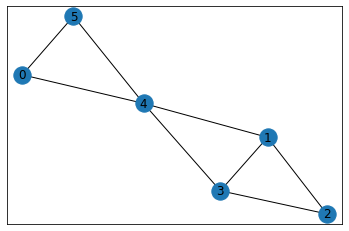

4 

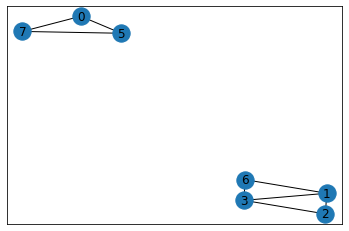

In [89]:
target2 = create_nx_graph([[1,2],[1,3],[1,4],[2,3],[3,4],[4,5],[4,0],[5,0]])
GraphVisualization(target2).visualize()
blocks2 = CutGraph(target2).cut()
GraphVisualization(blocks2).visualize()

In [90]:
nx.is_isomorphic(blocks, blocks2)

True

In [6]:
# print ("First 10 equivalence classes: ")

# for G in pruned_atlas(60)[40:]:
#     plot_graph(G[0])
#     plot_graph(G[1])
#     print(G[2])
# print ()

for i, G in enumerate(pruned_atlas(70)[:41]):
    if nx.is_isomorphic(G[1], target):
        print("found", i+40)
        GraphVisualization(G[0]).visualize()
        GraphVisualization(G[1]).visualize()
        GraphVisualization(target).visualize()
    elif nx.is_isomorphic(G[1], target2):
        print("found", i+40)
        GraphVisualization(G[0]).visualize()
        GraphVisualization(G[1]).visualize()
        GraphVisualization(target2).visualize()
# # index_in_atlas can be used to find the index of a graph
# atl = pruned_atlas(100)
# ind = index_in_atlas(atl, nx.complete_graph(4))
# print ("K_4 has index ", ind, "and edges ", atl[ind].edges())
# print ()

# #This is the list of coefficients, indexed in the same order that pruned_atlas outputs.
# COEFFS = [63.0, -30.0, 12.0, -63.0, 0.0, 6.0, -39.0, -1.926, 12.0, 5.478, 4.293, -16.5, 0.0, 0.0, 0.0, 0.0, -20.3, 24.75, 0.0, -2.274, 2, -11.528, 0.0, 0.0, -22.928, -12.8, 0.0, 0.0, 0.0, -1.2, -4.362, 0.0, 1.138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# #integer values
# COEFFS_INT = [int(1000 * x) for x in COEFFS]

# # For each graph G on 9 vertices and unlabeled H we need to know #{phi in [q]^{V(G)}: G_phi \cong H}
# # This is pre-computed and stored in subg_counts_9.npy


# # Checks prop 2.5 for graphs up to 9 vtx. 
# # Computes 1000 * (3^9) * mu(G).
# print ("Checking mu for graphs up to 9 vertices...")
# check_with_coeffs(COEFFS_INT)
# print()

# # Computes the maximum in Prop 3.5, multiplied by 324000 * (3^9) for integer arithmetic.
# print ("Bounding mu for graphs on more than 9 vertices...")
# count_bounds_with_coeffs(COEFFS_INT)

KeyError: 1